In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import leastsq
import scienceplots
#from photometric_models import HG, HG12, HG1G2
from db import query
import emcee
import corner

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}


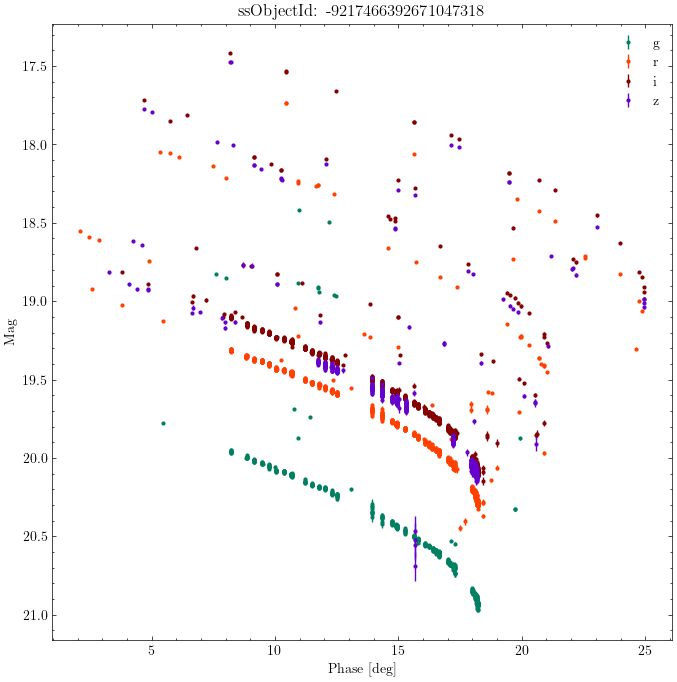

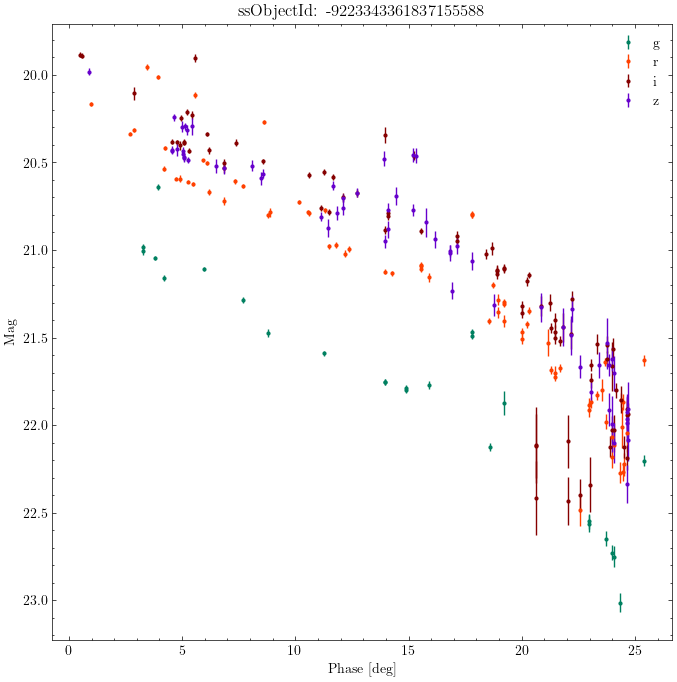

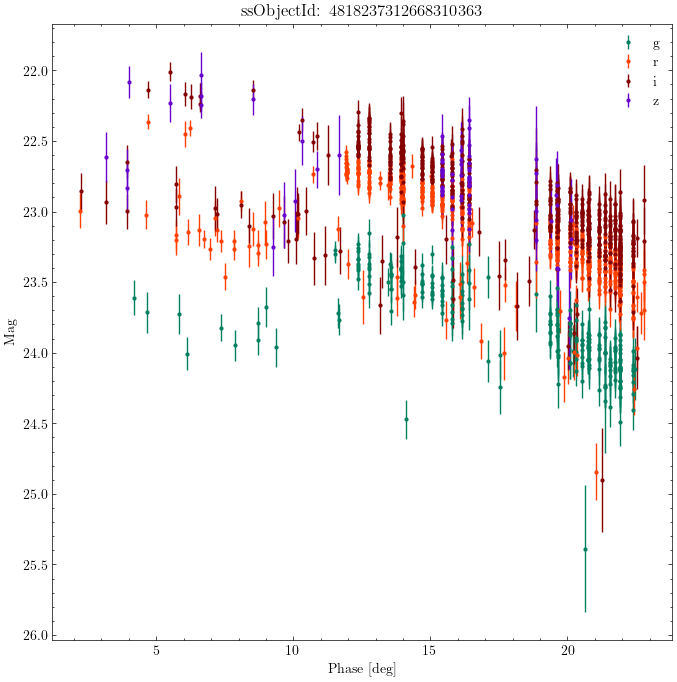

In [7]:
time = [
    61000,
    64000
]

obj_ids = [-9217466392671047318, -9223343361837155588, 4818237312668310363]

for obj_id in obj_ids:
    obj = query(
        f'''
        SELECT mag, magErr, band, phaseAngle, ds.ssObjectId
        FROM dp03_catalogs_10yr.DiaSource as ds
        LEFT JOIN dp03_catalogs_10yr.SSSource AS sso ON ds.diaSourceId = sso.diaSourceId
        WHERE ds.ssObjectId = {obj_id} AND  midPointMjdTai >= {time[0]} and midPointMjdTai <= {time[1]}
        '''
    )

    plt.figure(figsize=(8,8))
    for filt in filters:
        plt.errorbar(
            obj["phaseAngle"][obj["band"] == filt],
            obj["mag"][obj["band"] == filt],
            yerr=obj["magErr"][obj["band"] == filt],
            c=filter_colors[filt],
            markersize=2,
            marker="o",
            ls = "None",
            label=filt
        )
    plt.gca().invert_yaxis()
    plt.title(f"ssObjectId: {obj_id}")
    plt.xlabel("Phase [deg]")
    plt.ylabel("Mag")
    plt.legend()

Phase curve MCMC

In [8]:
# Fit using least squares - done

# Fit using likelihood - done

# Run MCMC

In [9]:
import numpy as np
from scipy.interpolate import CubicSpline 

A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2,
            3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2,
            1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1,
            1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]

phi_1 = CubicSpline(alpha_12, phi_1_sp,
                    bc_type=((1, phi_1_derivs[0]), (1, phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp,
                    bc_type=((1, phi_2_derivs[0]), (1, phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp,
                    bc_type=((1, phi_3_derivs[0]), (1, phi_3_derivs[1])))

def HG(phase, params):
    """
    Compute HG model phase curve for a given set
    of parameters. The simplest 2-parameter model.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters [H, G]

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)

    W = np.exp(-90.56 * tan_ah * tan_ah)
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)

    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina

    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))

    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L

    return params[0] - 2.5*np.log10((1-params[1]) * phi_1
                                    + (params[1]) * phi_2)


from sbpy.photometry import HG1G2 as HG1G2_sbpy

def HG1G2(phase, params):
    """
    Compute HG1G2 model phase curve for a given set
    of parameters. This is a 3-parameter model, which works best
    when sufficiently long phaseangle coverage is available.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters [H, G1, G2]

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    '''phi_1_ev = phi_1(phase)
    phi_2_ev = phi_2(phase)
    phi_3_ev = phi_3(phase)

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6 * phase[msk]/np.pi
    phi_2_ev[msk] = 1-9 * phase[msk]/(5 * np.pi)

    phi_3_ev[phase > np.pi/6] = 0
    
    

    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev
                                      + params[2] * phi_2_ev
                                      + (1-params[1]-params[2]) * phi_3_ev)
    '''
    
    return HG1G2_sbpy().evaluate(
        ph = phase,
        h = params[0],
        g1 = params[1],
        g2 = params[2]
    )

In [10]:
obj_id = 219932969194564477 #5530194465174644132 #4818237312668310363 #-9223343361837155588

obj = query(
    f'''
    SELECT mag, magErr, band, phaseAngle, heliocentricDist, topocentricDist, ds.ssObjectId, midPointMjdTai
    FROM dp03_catalogs_10yr.DiaSource as ds
    LEFT JOIN dp03_catalogs_10yr.SSSource AS sso ON ds.diaSourceId = sso.diaSourceId
    WHERE ds.ssObjectId = {obj_id}
    '''
)

In [11]:
def reduced_magnitude(mag, heliocentricDist, topocentricDist):
    return mag - 5.0*np.log10(heliocentricDist * topocentricDist)

def weighted_dev(params, mag, phase, mag_err, model):
    """
    Compute weighted deviation for a given model.
    
    Parameters
    ----------
    params: list
        phase curve parameters
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in radians
    mag_err: ndarray
        uncertainty in magnitude
    model: function
        phase curve model function
    

    Returns
    -------
    sol: tuple
        best-fit solution
    """

    pred = model(phase, params)

    return (mag - pred)/mag_err

def fitPhaseCurve(mag, phase, sigma, model=HG1G2, params=[0.1]):
    """
    Fit phase curve for given observations to a designated model.

    Parameters
    ----------
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in degrees
    sigma: ndarray
        uncertainty in magnitude
    model: function (default=HG12_model)
        phase curve model function
    params: list (default=[0.1])
        phase curve parameters

    Returns
    -------
    sol: tuple
        best-fit solution
    """

    phase = np.deg2rad(phase)

    sol = leastsq(weighted_dev, [mag[0]] + params, (mag, phase, sigma, model),
                  full_output=True)

    return sol

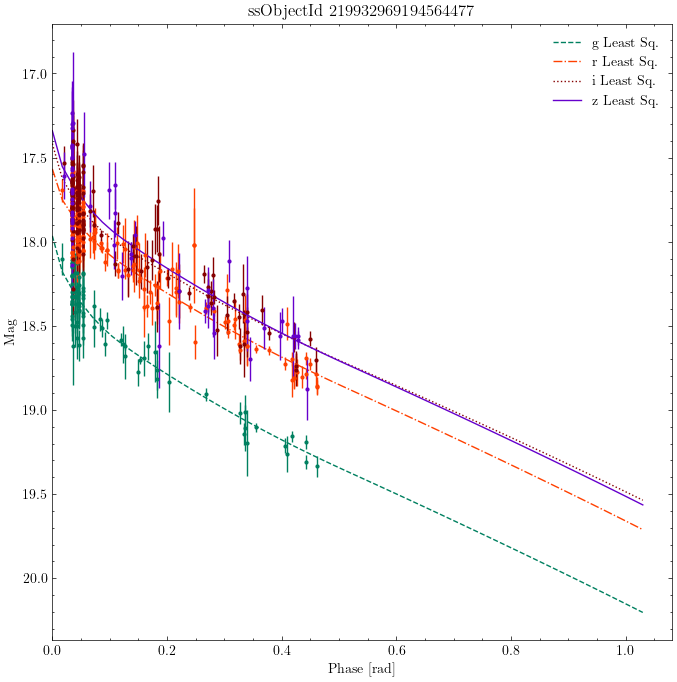

In [12]:
plt.figure(figsize=(8,8))

phases = np.arange(0, 60, 1)

for filt in filters:

    sol = fitPhaseCurve(
        mag = reduced_magnitude(obj["mag"][obj["band"] == filt], obj["heliocentricDist"][obj["band"] == filt], obj["topocentricDist"][obj["band"] == filt]),
        phase = obj["phaseAngle"][obj["band"] == filt],
        sigma = obj["magErr"][obj["band"] == filt],
        model=HG1G2,
        params = [0.1, 0.1]
    )
    plt.errorbar(
        np.deg2rad((obj["phaseAngle"][obj["band"] == filt])),
        reduced_magnitude(obj["mag"][obj["band"] == filt], obj["heliocentricDist"][obj["band"] == filt], obj["topocentricDist"][obj["band"] == filt]),
        yerr=obj["magErr"][obj["band"] == filt],
        c=filter_colors[filt],
        markersize=2,
        marker="o",
        ls = "None"
    )
    plt.plot(
        np.deg2rad(phases),
        HG1G2(
            phase=np.deg2rad(phases),
            params=sol[0]
        ),
        c=filter_colors[filt],
        label=f"{filt} Least Sq.",
        ls=linestyles[filt]
    )

plt.title(f"ssObjectId  {obj_id}")
plt.xlabel("Phase [rad]")
plt.xlim(0,)
plt.ylim()
plt.ylabel("Mag")
plt.gca().invert_yaxis()
plt.legend()

In [13]:
def log_likelihood(theta, phase, reducedMag, reducedMagErr):
    '''
    theta = [H, G1, G2, log_f]
    phase = [....] / radians
    reducedMag = ...
    '''
    model = HG1G2(
        phase=phase.astype("float64"),
        params = theta[0:3]
    )
    
    sigma2 = reducedMagErr**2 + model**2 * np.exp(2 * theta[3])
    return -0.5 * np.sum((reducedMag - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    H, G1, G2, log_f = theta
    if (G1 >= 0) and (G2 >= 0) and (1 - G1 - G2 >= 0):
        return 0
    return -np.inf

def log_probability(theta, phase, reducedMag, reducedMagErr):
    lp = log_prior(theta)
    ll = log_likelihood(theta, phase, reducedMag, reducedMagErr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

89 g


/Users/br/Desktop/msc_project/.venv/lib/python3.11/site-packages/sbpy/photometry/iau.py:348: RuntimeWarning: invalid value encountered in log10
  func = -2.5 * np.log10(func)


204 r
152 i


/Users/br/Desktop/msc_project/.venv/lib/python3.11/site-packages/sbpy/photometry/iau.py:348: RuntimeWarning: invalid value encountered in log10
  func = -2.5 * np.log10(func)
/Users/br/Desktop/msc_project/.venv/lib/python3.11/site-packages/sbpy/photometry/iau.py:348: RuntimeWarning: invalid value encountered in log10
  func = -2.5 * np.log10(func)


56 z


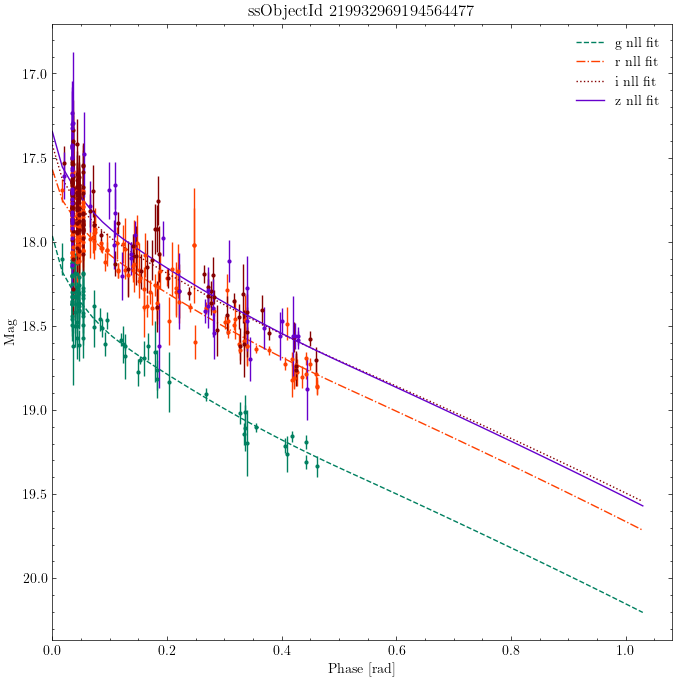

In [14]:
from scipy.optimize import minimize

np.random.seed(42)
plt.figure(figsize=(8,8))
for filt in filters:

    reducedMag = reduced_magnitude(obj["mag"][obj["band"] == filt], obj["heliocentricDist"][obj["band"] == filt], obj["topocentricDist"][obj["band"] == filt])
    sigma = obj["magErr"][obj["band"] == filt]
    phases = obj["phaseAngle"][obj["band"] == filt]

    print(len(reducedMag), filt)
    sol = fitPhaseCurve(
        mag = reducedMag,
        phase = phases,
        sigma = sigma,
        model=HG1G2,
        params = [0.1, 0.1]
    )
    #print(sol[0])
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([*sol[0], np.log(0.01)]) + 0.1 * np.random.randn(4)
    soln = minimize(nll, initial, args=(np.deg2rad(phases), reducedMag, sigma))
    
    plt.errorbar(
        np.deg2rad((obj["phaseAngle"][obj["band"] == filt])),
        reduced_magnitude(obj["mag"][obj["band"] == filt], obj["heliocentricDist"][obj["band"] == filt], obj["topocentricDist"][obj["band"] == filt]),
        yerr=obj["magErr"][obj["band"] == filt],
        c=filter_colors[filt],
        markersize=2,
        marker="o",
        ls = "None"
    )
    phases = np.arange(0, 60, 1)
    plt.plot(
        np.deg2rad(phases),
        HG1G2(
            phase=np.deg2rad(phases),
            params=soln.x[0:3]
        ),
        c=filter_colors[filt],
        ls=linestyles[filt],
        label=f"{filt} nll fit"
    )

plt.title(f"ssObjectId  {obj_id}")
plt.xlabel("Phase [rad]")
plt.xlim(0,)
plt.ylim()
plt.ylabel("Mag")
plt.gca().invert_yaxis()
plt.legend()

In [104]:
# Quote CI on the parameters.
# Check burn in
# Check convergence

# Read MCMC guide over

# Do for the object at different epochs of the survey, compare distributions of points at each epoch to the final obj measurement?

# What are the absolute best constraints can we put on these parameters? How good are these models?

In [3]:
from dr_downloader import survey_years
from astropy.time import Time

years = survey_years() # cache this

bands = np.array([["g", "r", "i", "z"] for i in range(len(years))]).reshape(1, 4*len(years)).tolist()[0]

catalog_delta = years[0].value[1][0] - years[0].value[0][0] # Time epoch for first year catalog
catalog_dates = []
catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0]], format="mjd"))

for i in range(1, 8):
    catalog_dates.append(Time([years[0].value[0][0], \
                years[0].value[1][0] + (i)*catalog_delta], format="mjd"))
catalog_dates.append(Time([years[0].value[0][0], \
                years[-1].value[1][0]], format="mjd"))

100%|██████████| 10000/10000 [02:28<00:00, 67.17it/s]


Mean acceptance fraction: 0.492
Mean autocorrelation time: 68.863 steps


100%|██████████| 10000/10000 [02:31<00:00, 65.92it/s]


Mean acceptance fraction: 0.497
Mean autocorrelation time: 62.146 steps


100%|██████████| 10000/10000 [02:31<00:00, 65.95it/s]


Mean acceptance fraction: 0.495
Mean autocorrelation time: 68.279 steps


100%|██████████| 10000/10000 [07:07<00:00, 23.41it/s] 


Mean acceptance fraction: 0.000
Mean autocorrelation time: nan steps


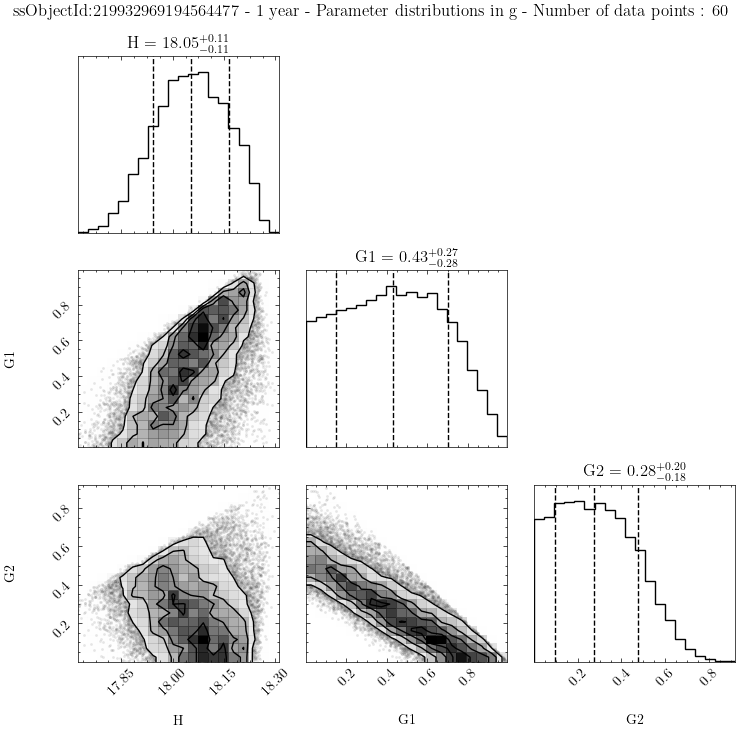

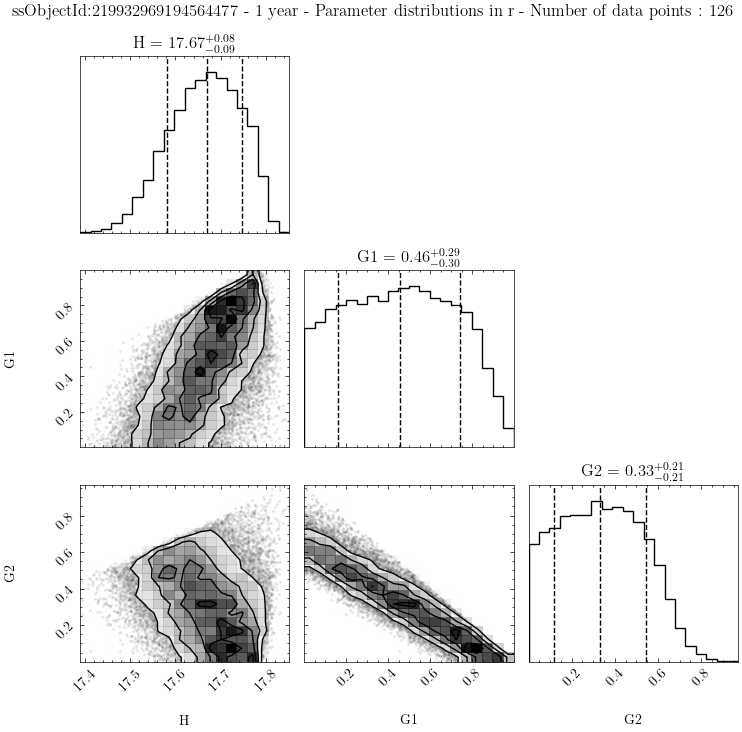

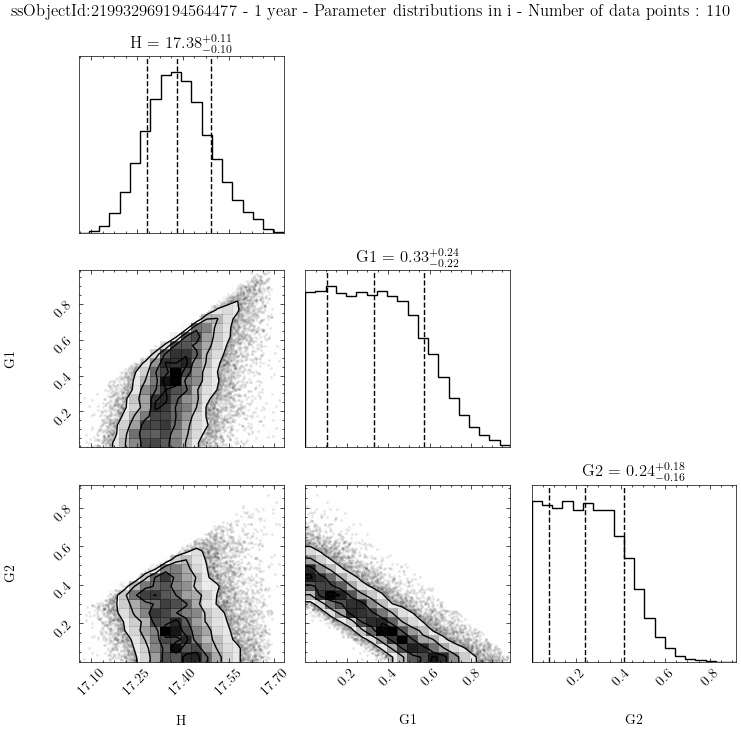

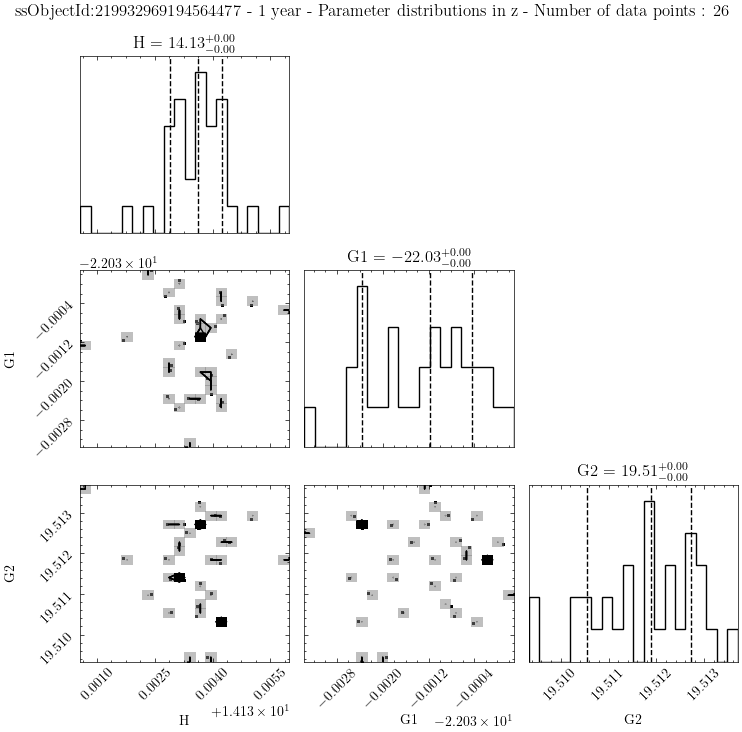

In [62]:
import warnings

warnings.filterwarnings("ignore") # Supress for bad fits

df = obj.to_table().to_pandas()
ndim = 4

filter_samples_1yr = {
    "g": [],
    "r": [],
    "i": [],
    "z": []
}

for date in catalog_dates[1:2]:
    df_ = df[df["midPointMjdTai"] <= date.value[1]]
    for filt in filters:
        reducedMag = reduced_magnitude(df_["mag"][df_["band"] == filt], df_["heliocentricDist"][df_["band"] == filt], df_["topocentricDist"][df_["band"] == filt]).to_numpy()
        
        if len(reducedMag) >= 10: # Need at least ten observations.
            sigma = df_["magErr"][df_["band"] == filt]
            phases = df_["phaseAngle"][df_["band"] == filt]
            
            sol = fitPhaseCurve(
                mag = reducedMag,
                phase = phases,
                sigma = sigma,
                model=HG1G2,
                params = [0.1, 0.1]
            )

            nll = lambda *args: -log_likelihood(*args)
            initial = np.array([*sol[0], np.log(0.1)]) + 0.1 * np.random.randn(4)
            soln = minimize(nll, initial, args=(np.deg2rad(phases), reducedMag, sigma)) # Pre-Fit

            pos = soln.x + 1e-3 * np.random.randn(32, ndim)
            
            nwalkers, ndim = pos.shape

            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(np.deg2rad(phases), reducedMag, sigma)
            )
            
            sampler.run_mcmc(pos, 10000, progress=True)

            print(
                "Mean acceptance fraction: {0:.3f}".format(
                np.mean(sampler.acceptance_fraction)
                )   
            )
            print(
                "Mean autocorrelation time: {0:.3f} steps".format(
                    np.mean(sampler.get_autocorr_time())
                )
            )

            '''fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
            samples = sampler.get_chain()
            labels = ["H", "G1", "G2","log(f)"]
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number")
            '''
            flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
            filter_samples_1yr[filt].append(flat_samples)

            data = pd.DataFrame(
                flat_samples[:, 0:3],
                columns=["H", "G1", "G2"]
            )

            figure = corner.corner(
                data,
                labels=["H", "G1", "G2"],
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 12},
            )
            figure.suptitle(f"ssObjectId:{obj_id} - 1 year - Parameter distributions in {filt} - Number of data points : {len(reducedMag)}")
            figure.tight_layout()
            del data

100%|██████████| 10000/10000 [02:33<00:00, 65.11it/s]


Mean acceptance fraction: 0.559
Mean autocorrelation time: 51.694 steps


100%|██████████| 10000/10000 [02:36<00:00, 63.81it/s]


Mean acceptance fraction: 0.559
Mean autocorrelation time: 55.606 steps


100%|██████████| 10000/10000 [02:38<00:00, 62.96it/s]


Mean acceptance fraction: 0.538
Mean autocorrelation time: 57.003 steps


100%|██████████| 10000/10000 [02:36<00:00, 64.03it/s]


Mean acceptance fraction: 0.530
Mean autocorrelation time: 62.855 steps


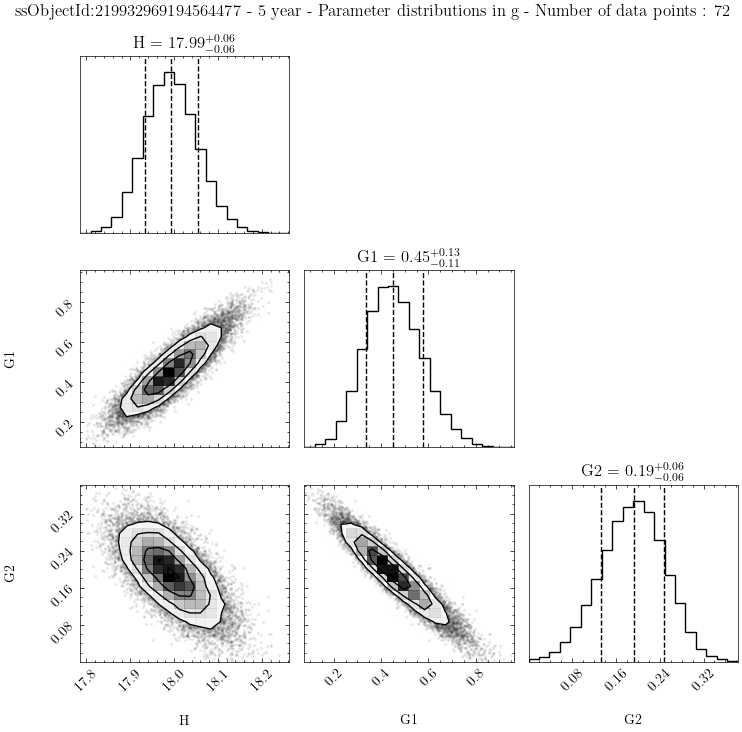

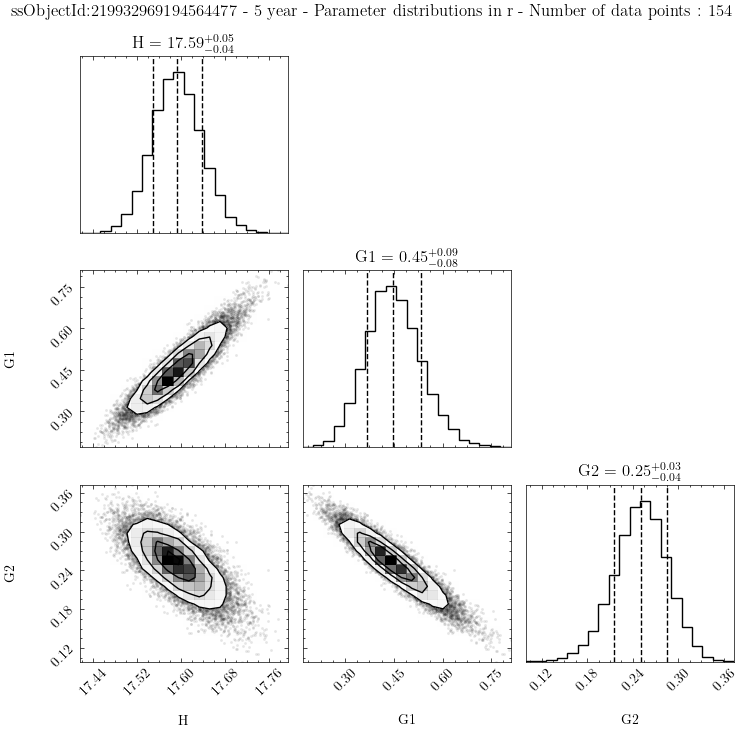

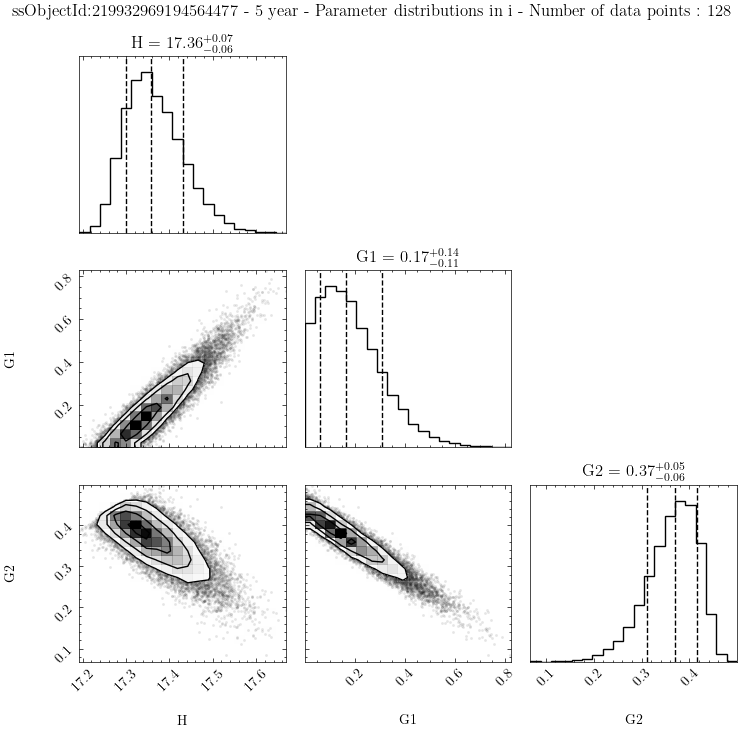

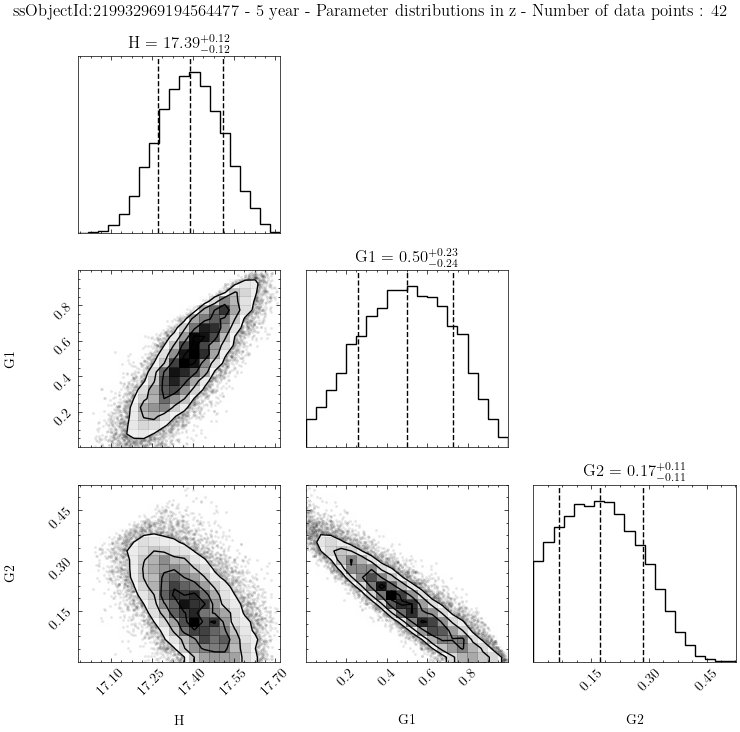

In [111]:
df = obj.to_table().to_pandas()
filter_samples_5yr = {
    "g": [],
    "r": [],
    "i": [],
    "z": []
}

for date in catalog_dates[4:5]:
    df_ = df[df["midPointMjdTai"] <= date.value[1]]
    for filt in filters:
        reducedMag = reduced_magnitude(df_["mag"][df_["band"] == filt], df_["heliocentricDist"][df_["band"] == filt], df_["topocentricDist"][df_["band"] == filt]).to_numpy()
        
        if len(reducedMag) >= 10: # Need at least ten observations.
            sigma = df_["magErr"][df_["band"] == filt]
            phases = df_["phaseAngle"][df_["band"] == filt]
            
            sol = fitPhaseCurve(
                mag = reducedMag,
                phase = phases,
                sigma = sigma,
                model=HG1G2,
                params = [0.1, 0.1]
            )

            nll = lambda *args: -log_likelihood(*args)
            initial = np.array([*sol[0], np.log(0.1)]) + 0.1 * np.random.randn(4)
            soln = minimize(nll, initial, args=(np.deg2rad(phases), reducedMag, sigma)) # Pre-Fit

            pos = soln.x + 1e-3 * np.random.randn(32, ndim)
            
            nwalkers, ndim = pos.shape

            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(np.deg2rad(phases), reducedMag, sigma)
            )
            
            sampler.run_mcmc(pos, 10000, progress=True)

            print(
                "Mean acceptance fraction: {0:.3f}".format(
                np.mean(sampler.acceptance_fraction)
                )   
            )
            print(
                "Mean autocorrelation time: {0:.3f} steps".format(
                    np.mean(sampler.get_autocorr_time())
                )
            )

            '''fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
            samples = sampler.get_chain()
            labels = ["H", "G1", "G2","log(f)"]
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number")
            '''
            flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
            filter_samples_5yr[filt].append(flat_samples)

            data = pd.DataFrame(
                flat_samples[:, 0:3],
                columns=["H", "G1", "G2"]
            )

            figure = corner.corner(
                data,
                labels=["H", "G1", "G2"],
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 12},
            )
            figure.suptitle(f"ssObjectId:{obj_id} - 5 year  - Parameter distributions in {filt} - Number of data points : {len(reducedMag)}")
            figure.tight_layout()
            del data

100%|██████████| 10000/10000 [15:56<00:00, 10.45it/s]  


Mean acceptance fraction: 0.559
Mean autocorrelation time: 51.649 steps


100%|██████████| 10000/10000 [02:42<00:00, 61.61it/s]


Mean acceptance fraction: 0.558
Mean autocorrelation time: 50.405 steps


100%|██████████| 10000/10000 [02:41<00:00, 61.79it/s]


Mean acceptance fraction: 0.558
Mean autocorrelation time: 53.594 steps


100%|██████████| 10000/10000 [02:39<00:00, 62.67it/s]


Mean acceptance fraction: 0.545
Mean autocorrelation time: 57.463 steps


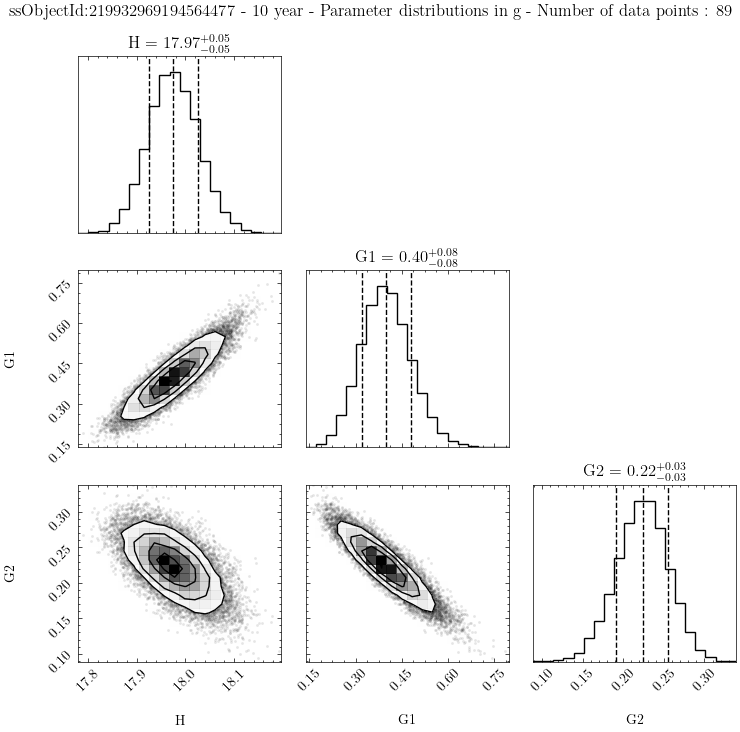

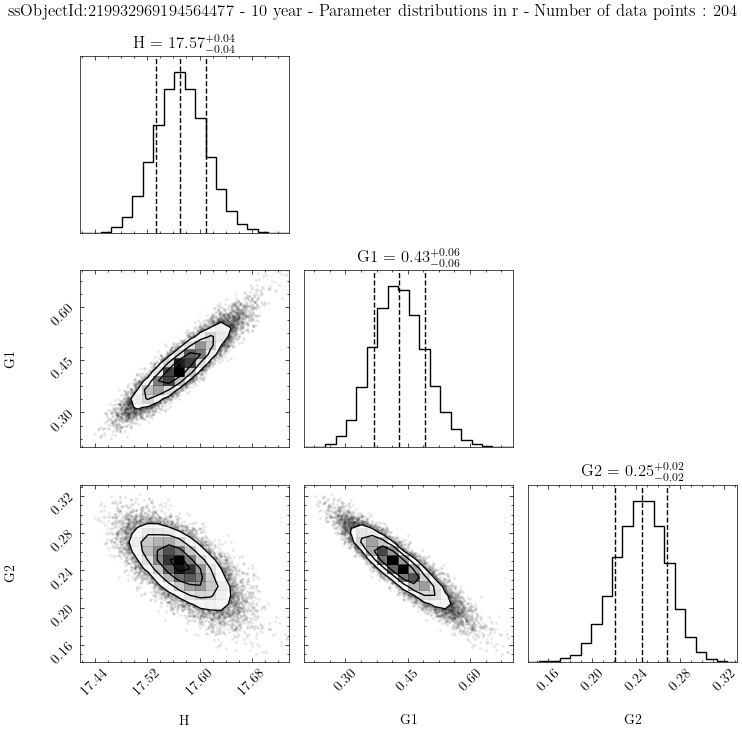

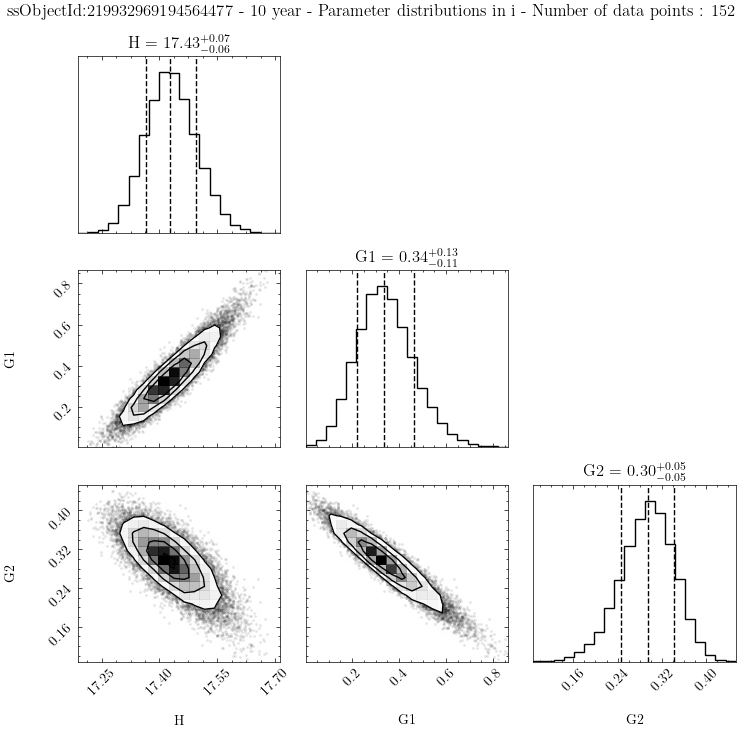

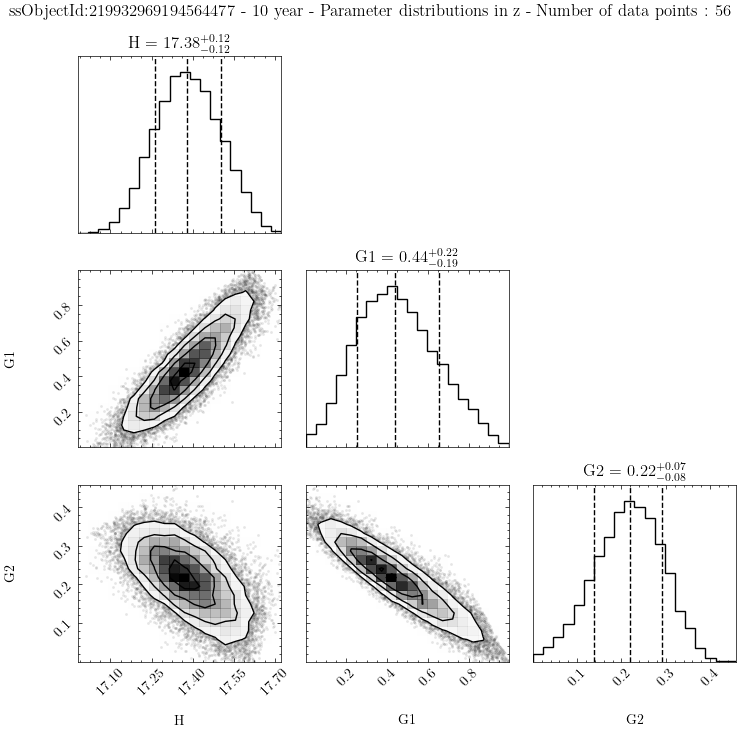

In [63]:
df = obj.to_table().to_pandas()
filter_samples_10yr = {
    "g": [],
    "r": [],
    "i": [],
    "z": []
}

for date in catalog_dates[-1:]:
    df_ = df[df["midPointMjdTai"] <= date.value[1]]
    for filt in filters:
        reducedMag = reduced_magnitude(df_["mag"][df_["band"] == filt], df_["heliocentricDist"][df_["band"] == filt], df_["topocentricDist"][df_["band"] == filt]).to_numpy()
        
        if len(reducedMag) >= 10: # Need at least ten observations.
            sigma = df_["magErr"][df_["band"] == filt]
            phases = df_["phaseAngle"][df_["band"] == filt]
            
            sol = fitPhaseCurve(
                mag = reducedMag,
                phase = phases,
                sigma = sigma,
                model=HG1G2,
                params = [0.1, 0.1]
            )

            nll = lambda *args: -log_likelihood(*args)
            initial = np.array([*sol[0], np.log(0.1)]) + 0.1 * np.random.randn(4)
            soln = minimize(nll, initial, args=(np.deg2rad(phases), reducedMag, sigma)) # Pre-Fit

            pos = soln.x + 1e-3 * np.random.randn(32, ndim)
            
            nwalkers, ndim = pos.shape

            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(np.deg2rad(phases), reducedMag, sigma)
            )
            
            sampler.run_mcmc(pos, 10000, progress=True)

            print(
                "Mean acceptance fraction: {0:.3f}".format(
                np.mean(sampler.acceptance_fraction)
                )   
            )
            print(
                "Mean autocorrelation time: {0:.3f} steps".format(
                    np.mean(sampler.get_autocorr_time())
                )
            )

            '''fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
            samples = sampler.get_chain()
            labels = ["H", "G1", "G2","log(f)"]
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number")
            '''
            flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
            filter_samples_10yr[filt].append(flat_samples)

            data = pd.DataFrame(
                flat_samples[:, 0:3],
                columns=["H", "G1", "G2"]
            )

            figure = corner.corner(
                data,
                labels=["H", "G1", "G2"],
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True,
                title_kwargs={"fontsize": 12},
            )
            figure.suptitle(f"ssObjectId:{obj_id} - 10 year  - Parameter distributions in {filt} - Number of data points : {len(reducedMag)}")
            figure.tight_layout()
            del data

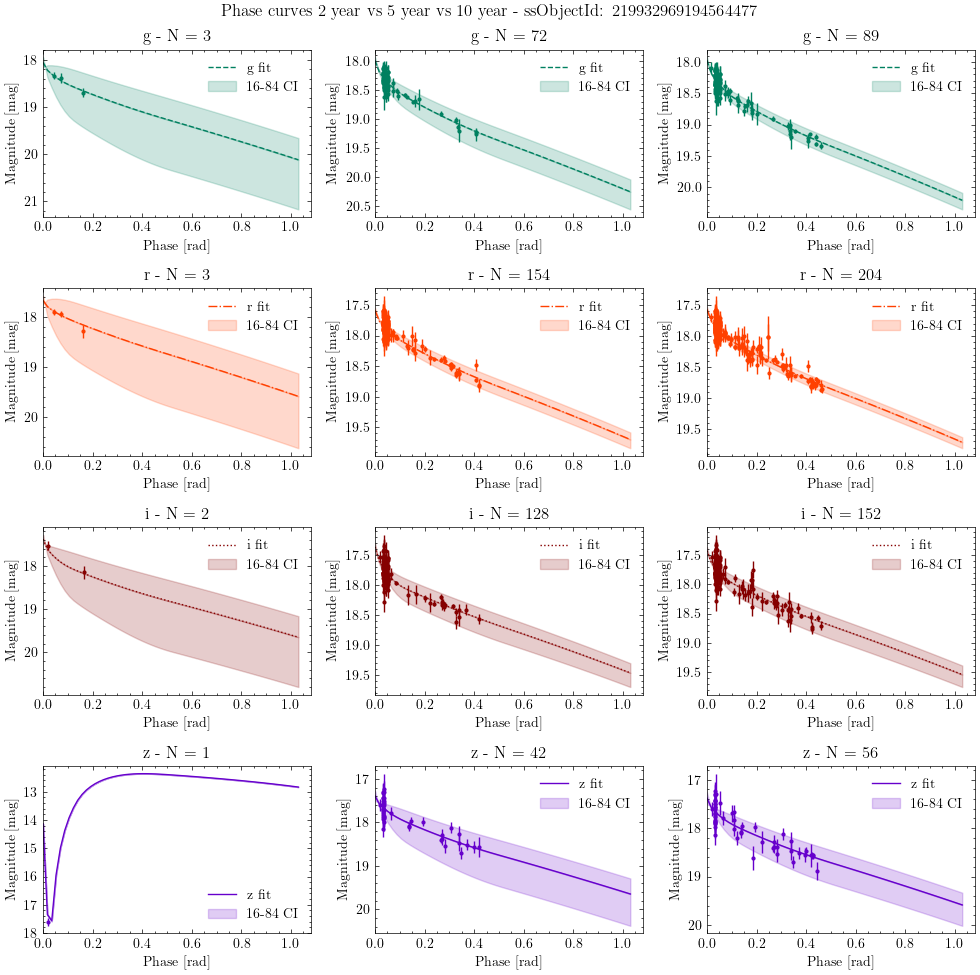

In [116]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))

for filt, row in zip(filters, axs):
    for i, col in enumerate(row):
        if i == 0:
            mask = (obj["band"] == filt) & (obj["midPointMjdTai"] <= catalog_dates[0].value[1])
            samples = filter_samples_1yr[filt][0]
        elif i == 1:
            mask = (obj["band"] == filt) & (obj["midPointMjdTai"] <= catalog_dates[4].value[1])
            samples = filter_samples_5yr[filt][0]
        else:
            mask = (obj["band"] == filt)
            samples = filter_samples_10yr[filt][0]

        reducedMag = reduced_magnitude(obj["mag"][mask], obj["heliocentricDist"][mask], obj["topocentricDist"][mask])
        sigma = obj["magErr"][mask]
        phases = obj["phaseAngle"][mask]

        col.errorbar(
            np.deg2rad((obj["phaseAngle"][mask])),
            reducedMag,
            yerr=obj["magErr"][mask],
            c=filter_colors[filt],
            markersize=2,
            marker="o",
            ls = "None"
        )
        phases = np.arange(0, 60, 1)
        fitReducedMag = HG1G2(
            phase=np.deg2rad(phases),
            params=[np.median(samples[:, k]) for k in range(3)]
        )
        col.plot(
            np.deg2rad(phases),
            fitReducedMag,
            c=filter_colors[filt],
            ls=linestyles[filt],
            label=f"{filt} fit"
        )
        col.fill_between(
            np.deg2rad(phases),
            fitReducedMag,
            HG1G2(
                phase=np.deg2rad(phases),
                params=[np.percentile(samples[:, k], 84) for k in range(3)]
            ),
            color=filter_colors[filt],
            alpha=0.2
        )
        col.fill_between(
            np.deg2rad(phases),
            fitReducedMag,
            HG1G2(
                phase=np.deg2rad(phases),
                params=[np.percentile(samples[:, k], 16) for k in range(3)]
            ),
            color=filter_colors[filt],
            alpha=0.2,
            label="16-84 CI"
        )

        col.set_title(f"{filt} - N = {len(reducedMag)}")
        col.set_xlabel("Phase [rad]")
        col.set_xlim(0,)
        col.invert_yaxis()
        col.set_ylabel("Magnitude [mag]")
        col.legend()
plt.suptitle(f"Phase curves 2 year vs 5 year vs 10 year - ssObjectId: {obj_id}")           
plt.tight_layout()

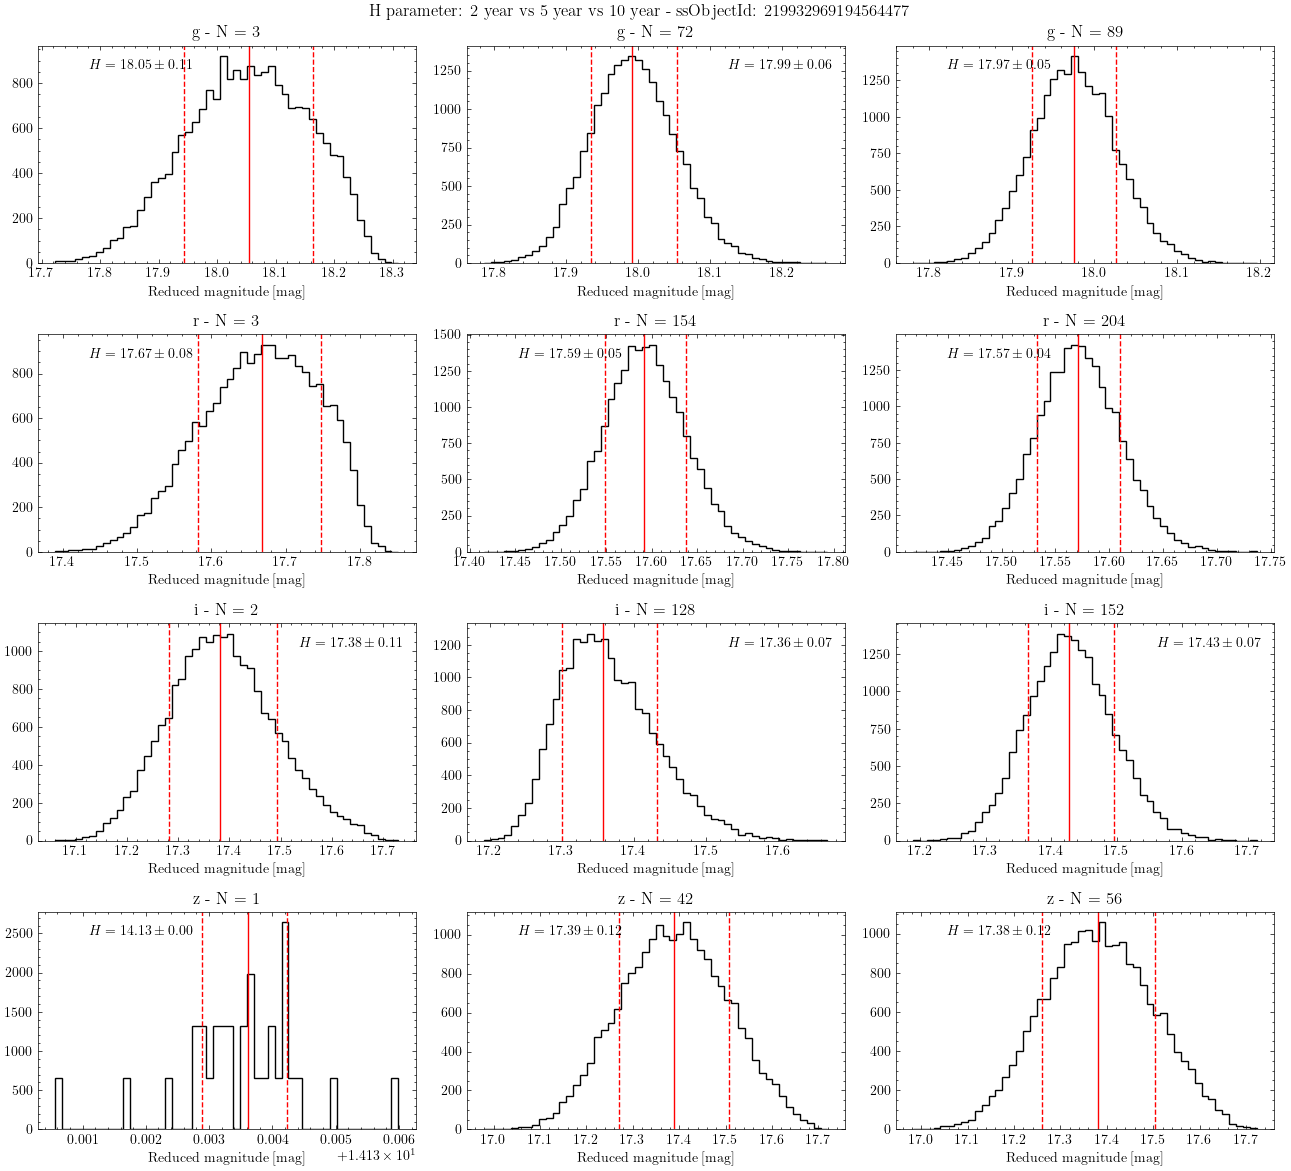

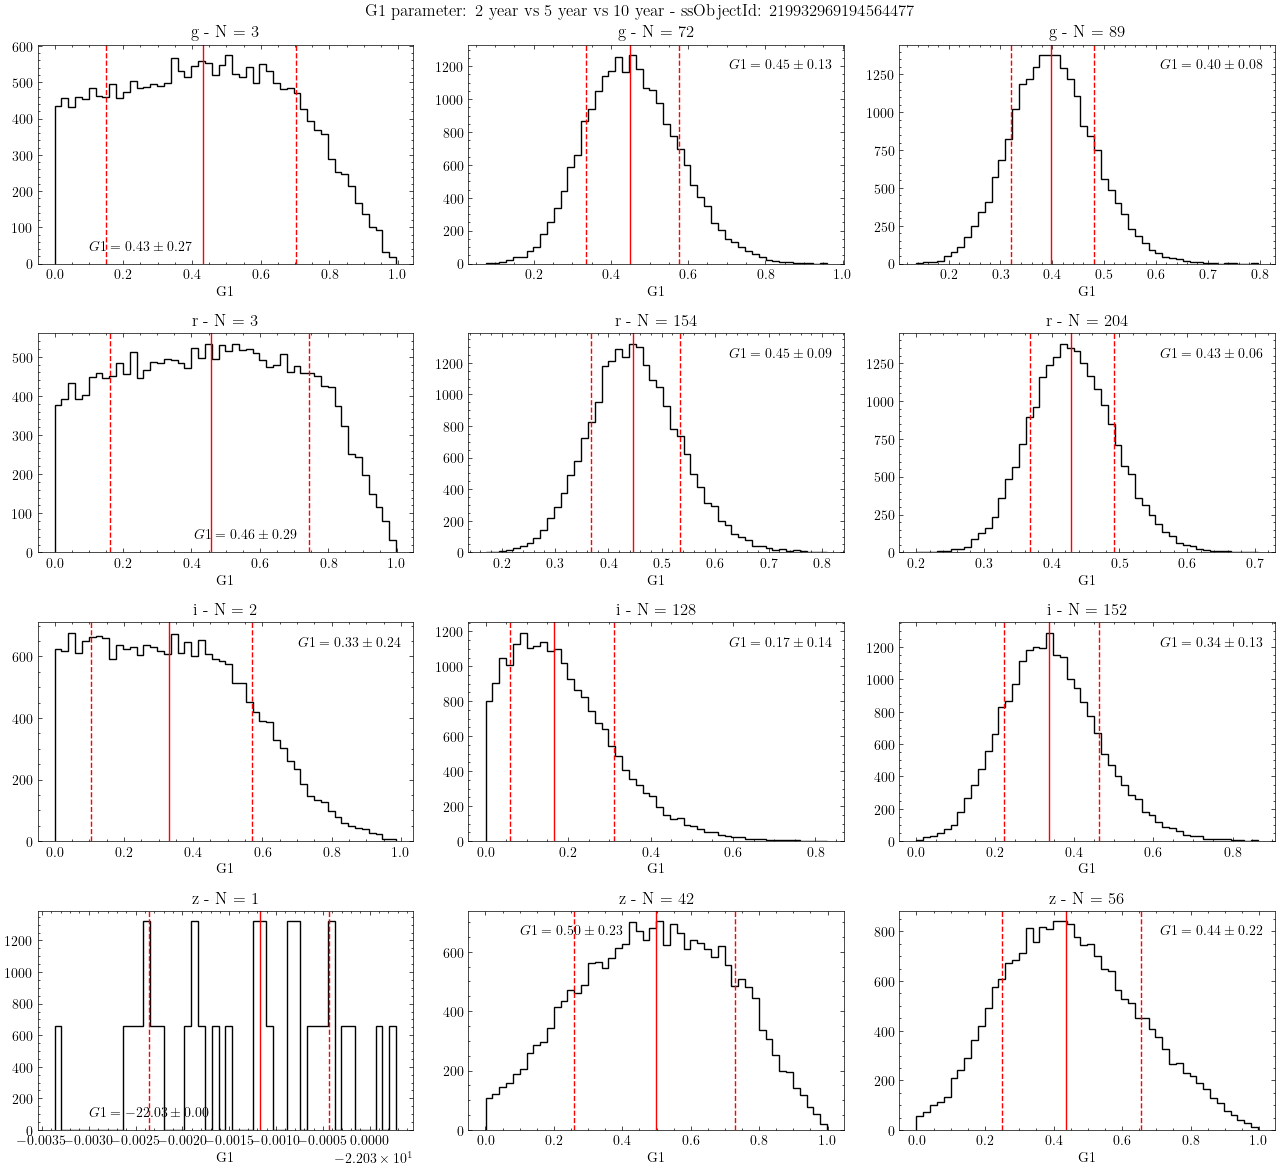

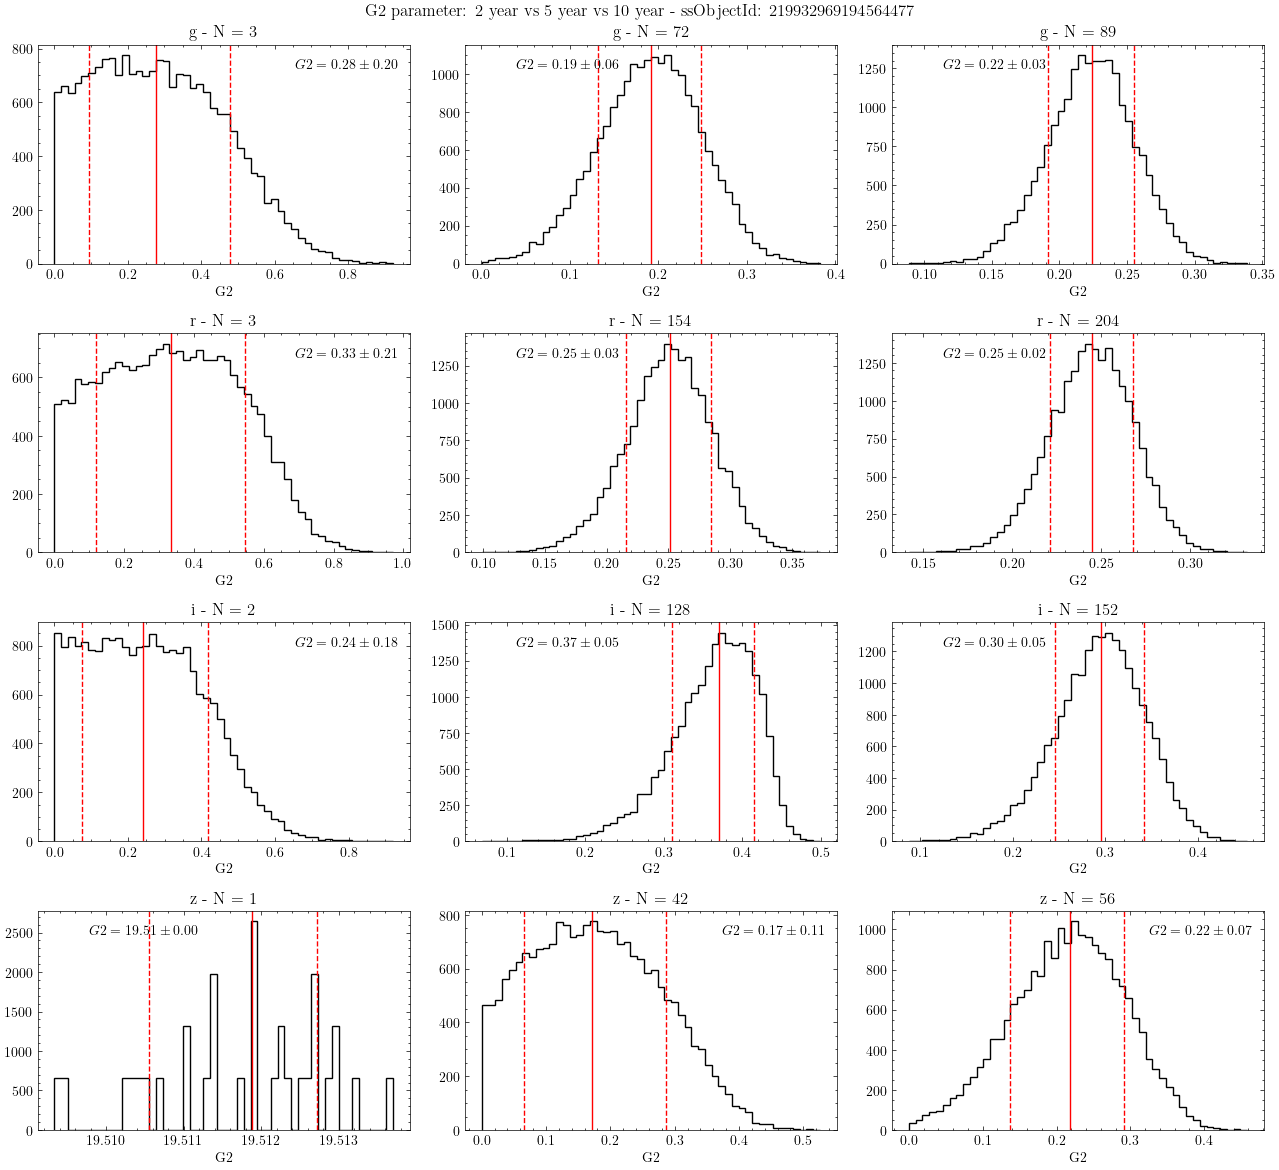

In [143]:
for parameter_num, parameter in enumerate(["H", "G1", "G2"]):
    fig, axs = plt.subplots(4, 3, figsize=(13,12))

    for filt, row in zip(filters, axs):
        for i, col in enumerate(row):
            if i == 0:
                mask = (obj["band"] == filt) & (obj["midPointMjdTai"] <= catalog_dates[0].value[1])
                samples = filter_samples_1yr[filt][0]
            elif i == 1:
                mask = (obj["band"] == filt) & (obj["midPointMjdTai"] <= catalog_dates[4].value[1])
                samples = filter_samples_5yr[filt][0]
            else:
                mask = (obj["band"] == filt)
                samples = filter_samples_10yr[filt][0]

            reducedMag = reduced_magnitude(obj["mag"][mask], obj["heliocentricDist"][mask], obj["topocentricDist"][mask])
            sigma = obj["magErr"][mask]
            phases = obj["phaseAngle"][mask]

            col.hist(
                samples[:, parameter_num],
                bins=50,
                histtype="step",
                color="black"
            )
            col.axvline(
                np.median(samples[:, parameter_num]),
                c="red"
            )
            col.axvline(
                np.percentile(samples[:, parameter_num], 16),
                c="red",
                ls="--"
            )
            col.axvline(
                np.percentile(samples[:, parameter_num], 84),
                c="red",
                ls="--",
            )
            col.axvline(
                np.percentile(samples[:, parameter_num], 84),
                c="None",
                ls="--",
                label=r"${parameter} = {H:.2f} \pm {err:.2f}$".format(parameter = parameter, H = np.median(samples[:, parameter_num]), err = np.percentile(samples[:, parameter_num], 84) - np.median(samples[:, parameter_num])),
            )
            col.set_title(f"{filt} - N = {len(reducedMag)}")
            if parameter == "H":
                col.set_xlabel("Reduced magnitude [mag]")
            else:
                col.set_xlabel(parameter)
            col.legend()

    plt.suptitle(f"{parameter} parameter: 2 year vs 5 year vs 10 year - ssObjectId: {obj_id}")           
    plt.tight_layout()
    plt.show()

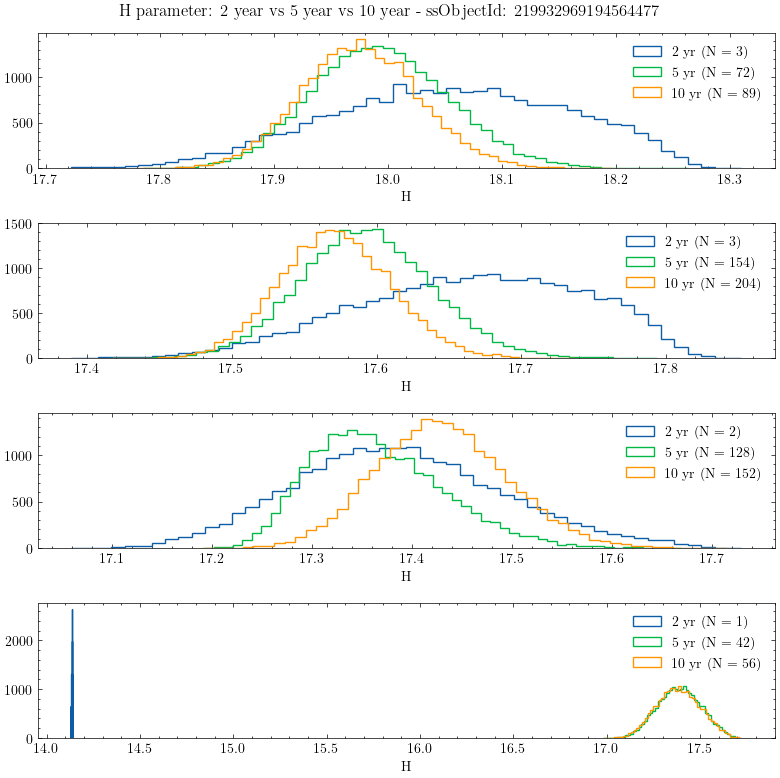

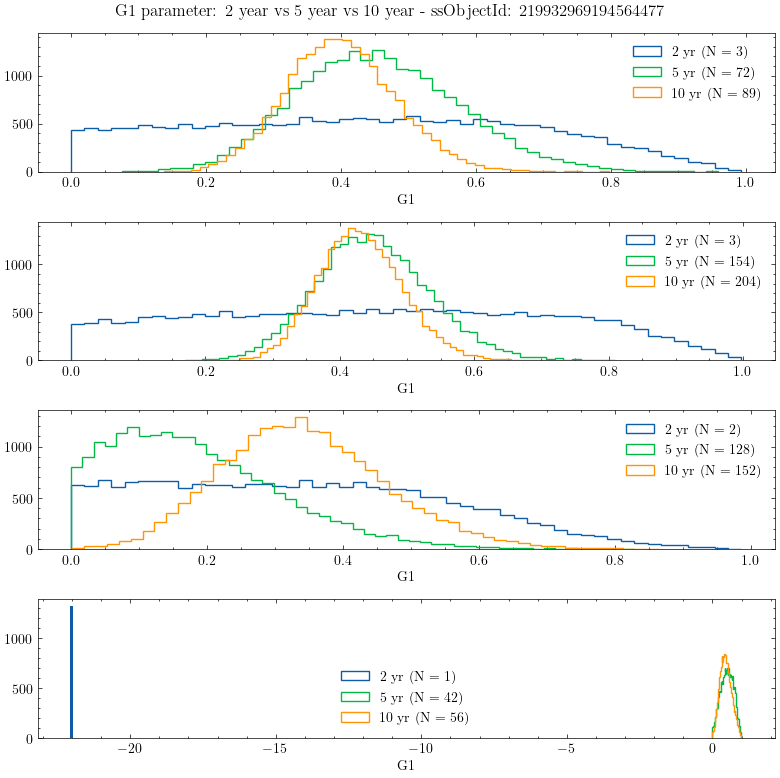

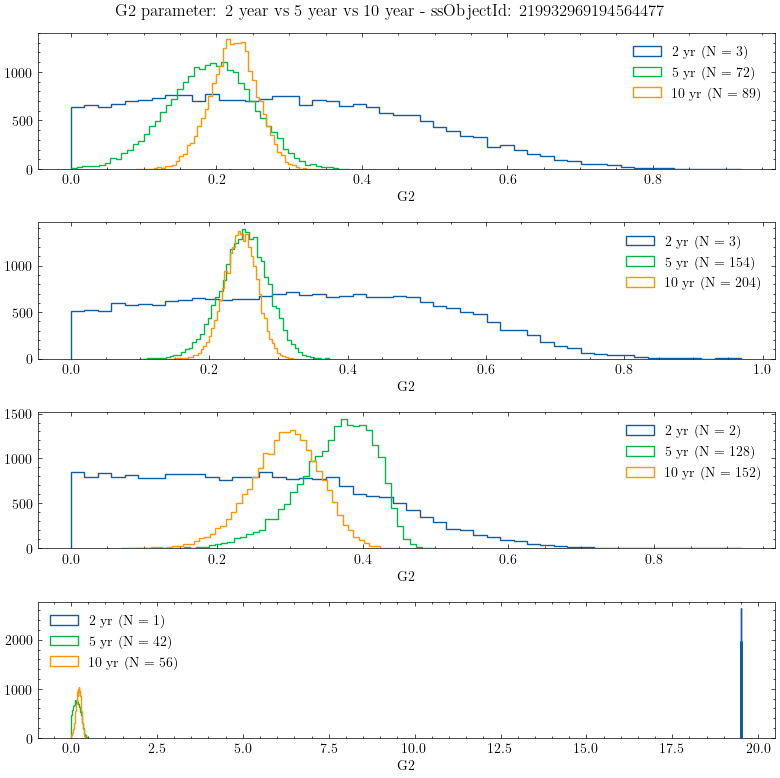

In [150]:
for parameter_num, parameter in enumerate(["H", "G1", "G2"]):
    fig, axs = plt.subplots(4, 1, figsize=(8,8))

    for filt, row in zip(filters, axs):
        for i in range(3):
            if i == 0:
                mask = (obj["band"] == filt) & (obj["midPointMjdTai"] <= catalog_dates[0].value[1])
                samples = filter_samples_1yr[filt][0]
                label = "2 yr"
            elif i == 1:
                mask = (obj["band"] == filt) & (obj["midPointMjdTai"] <= catalog_dates[4].value[1])
                samples = filter_samples_5yr[filt][0]
                label = "5 yr"
            else:
                mask = (obj["band"] == filt)
                samples = filter_samples_10yr[filt][0]
                label = "10 yr"

            reducedMag = reduced_magnitude(obj["mag"][mask], obj["heliocentricDist"][mask], obj["topocentricDist"][mask])

            row.hist(
                samples[:, parameter_num],
                bins=50,
                histtype="step",
                label=f"{label} (N = {len(reducedMag)})"
                #color="black"
            )
            row.legend()
            row.set_xlabel(parameter)
    plt.suptitle(f"{parameter} parameter: 2 year vs 5 year vs 10 year - ssObjectId: {obj_id}")           
    plt.tight_layout()
    plt.show()

In [157]:
from scipy.spatial.distance import minkowski

In [158]:
minkowski(
    filter_samples_1yr["g"][0][:, 0],
    filter_samples_10yr["g"][0][:, 0]
)

20.231802165502547